# Viscoporoelastic Model Inversion
Rahul Yerrabelli
2021

# Setup

In [1]:
#@title ## Basic imports

import sys
print(sys.version)
import importlib  # for reloading imports to source functions
#from IPython.display import HTML, Math
import IPython.display
import os

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections

import warnings
warnings.simplefilter("default")
#warnings.simplefilter('error'). # throws all warnings as errors
# How to display stack traces, options: Plain, Context (default), Verbose
%xmode Context 
# Turn on or off to cause debug mode to auto enter if exception is thrown
%pdb off

# Below code allows latex to be formatted nicely as google colab output
# Source: https://stackoverflow.com/a/61876185/2879686
def load_mathjax_in_cell_output():
  display(IPython.display.HTML("<script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register("pre_run_cell", load_mathjax_in_cell_output)

# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Exception reporting mode: Context
Automatic pdb calling has been turned OFF


In [2]:
#@title ## Mount google drive and import my code

try:
    from google.colab import drive
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    mountpoint_folder_name = "gdrive"  # can be anything, doesn't have to be drive
    drive.mount(os.path.join("/content/",mountpoint_folder_name))  # mounts to a folder called mountpoint_folder_name
    new_path = os.path.join("/content/",mountpoint_folder_name,
                            "MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src")
    if new_path not in sys.path:
      sys.path.insert(0,new_path)
except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()

#from src.euler_inversion import euler_inversion
#from src import plotting
#from src import viscoporoelastic_model
#from src.viscoporoelastic_model import ViscoporoelasticModel
from euler_inversion import euler_inversion
import plotting
import viscoporoelastic_model

<IPython.core.display.Javascript object>

Mounted at /content/gdrive


/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/plotting.py:115: DeprecationWarning: invalid escape sequence \s
  }"""
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Key Points from Prior Paper
Yuan, D., Somers, S.M., Grayson, W.L. et al. A Poroelastic Model of a Fibrous-Porous Tissue Engineering Scaffold. Sci Rep 8, 5043 (2018). https://doi.org/10.1038/s41598-018-23214-8

## Figure 1
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-018-23214-8/MediaObjects/41598_2018_23214_Fig1_HTML.jpg?as=webp">

## Table 1
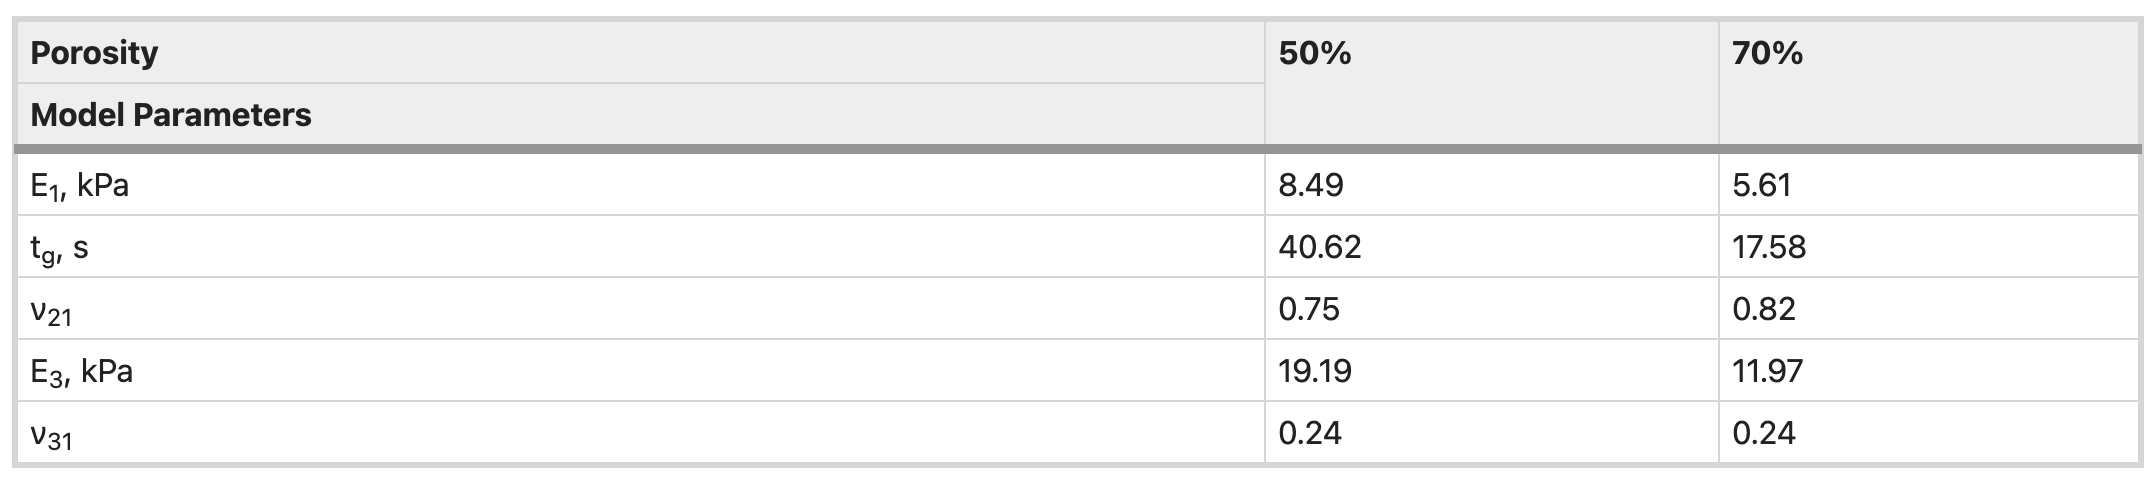

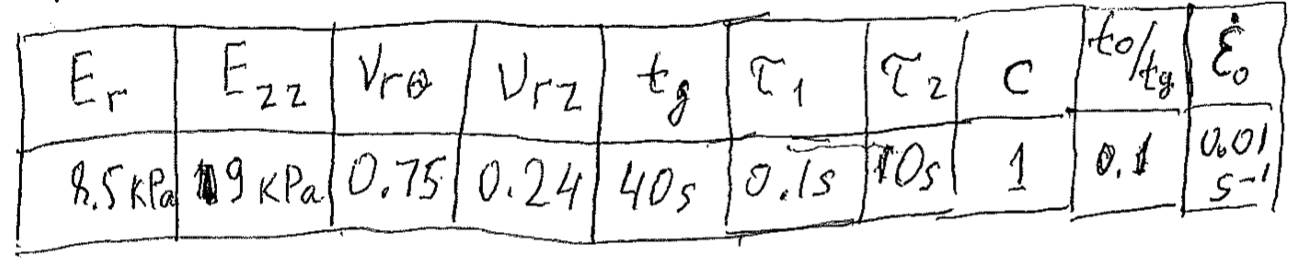

# Simple Laplace Model Inversion
$$ F(s)=\frac{1}{s-a} $$

<IPython.core.display.Javascript object>

/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/plotting.py:99: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/plotting.py:111: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


It took 0.0000 sec to evaluate the Laplace space func for 100 input s vals.
It took 0.0108 sec to numerically invert Laplace the func for 999 input times.


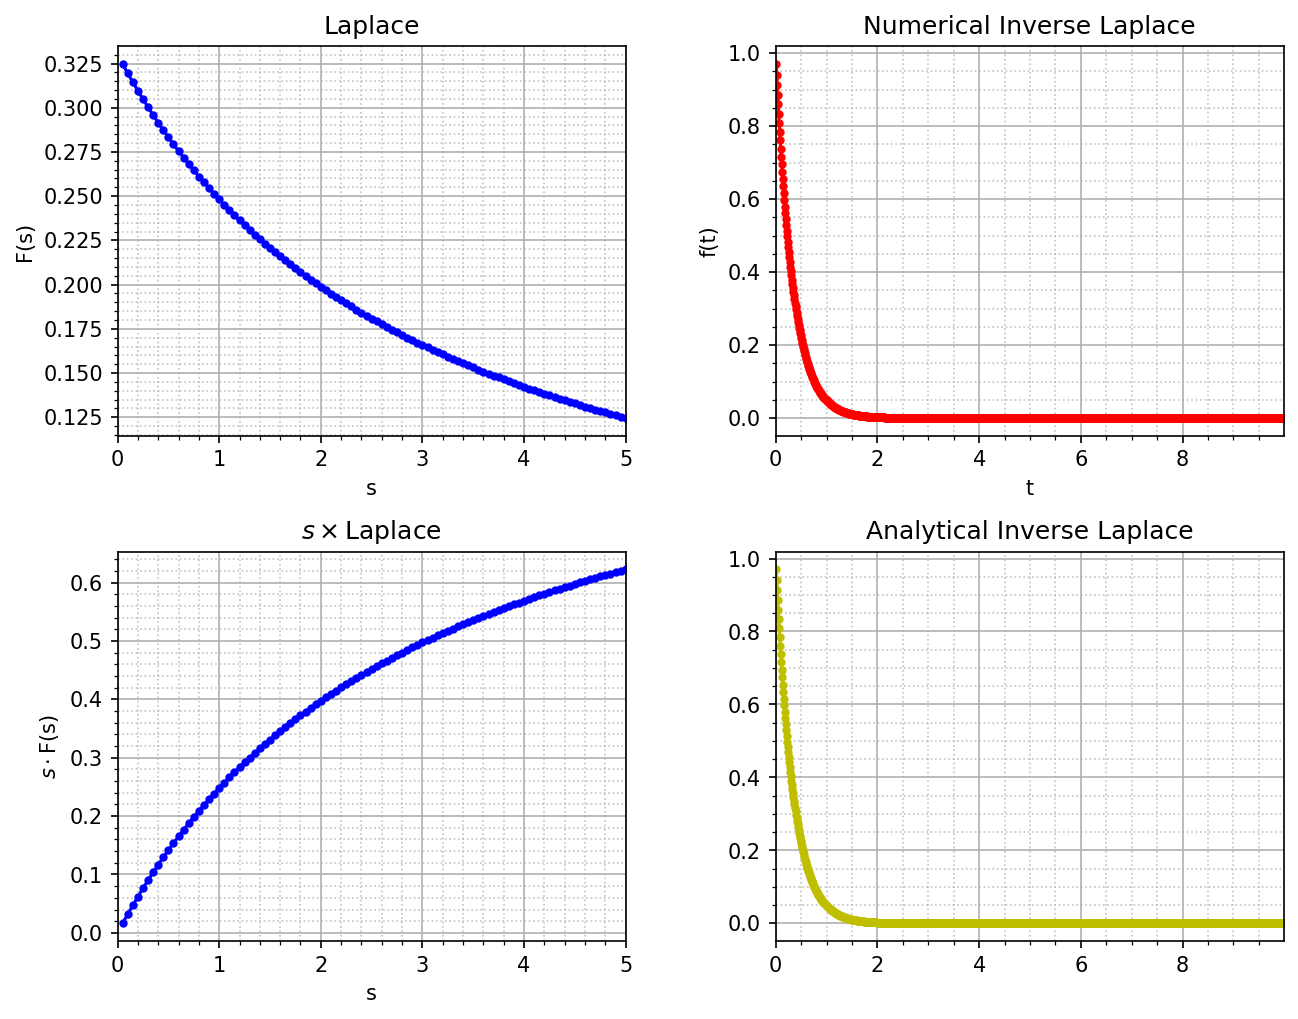

In [ ]:
#@markdown Simple Laplace - Numerical Inversion

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

anal_offset = 1
# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
times=np.arange(0.1,100,0.1)/10000.0*10*anal_offset
times=np.arange(0.1,100,0.1)/100.0*10*anal_offset

# \rm gives roman style letters, which is indicative of a constant
#@markdown $$ F(s)=\frac{1}{s-a} $$
#@markdown $$ f(t)={\rm{e}}^{a t}$$.
a = -3.03 #@param {type:"number"}
funcs = lambda s: 1/(s-a)
inv_funcs_anal = lambda t: np.exp(a*t)

input_times = times
plot_times  = times
func_name = {"t":"f(t)", "s":"F(s)"}
x_names   = {"t":"t", "s":"s"}
input_s = np.arange(0.05, 5.05, 0.05)
input_times_anal = input_times /anal_offset
plot_times_anal = plot_times /anal_offset


fig=plotting.plot_laplace_analysis(funcs=funcs, func_name=func_name, time_const=1, x_names=x_names, input_s=input_s, input_times=input_times, plot_times=plot_times, input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_func_anal )


# Viscoporoelastic model inversion

<IPython.core.display.Javascript object>

It took 0.0251 sec to evaluate the Laplace space func for 1097 input s vals.
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
It took 1.0897 sec to numerically invert Laplace the func for 1001 input times.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,t0/tg,strain_rate,Vrz,Ezz,c,tau1,tau2,tg,Vrtheta,Err
ViscoporoelasticModel1 - Line #1,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.700,8.49
ViscoporoelasticModel1 - Line #2,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.725,8.49
ViscoporoelasticModel1 - Line #3,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.750,8.49
ViscoporoelasticModel1 - Line #4,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.775,8.49
ViscoporoelasticModel1 - Line #5,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.800,8.49


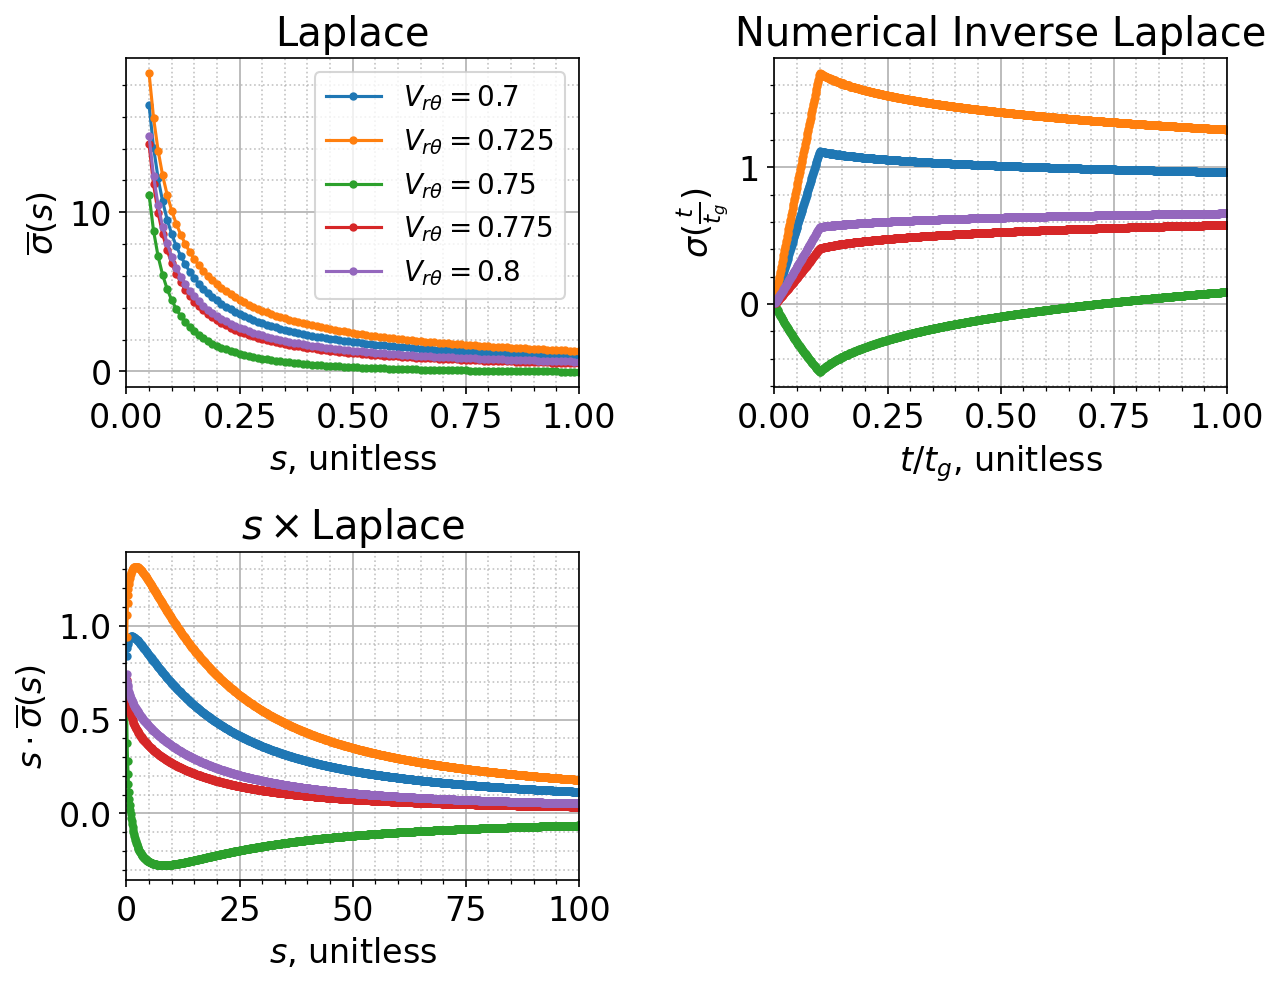

In [22]:
#@title # ViscoporoelasticModel1


importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel1

#warnings.simplefilter('error') # throws all warnings as errors
#%pdb off

#@markdown Predefined constants
ViscoporoelasticModel1.t0_tg = 0.1 #@param {type:"number"} ; # 10 percent
ViscoporoelasticModel1.strain_rate = 0.01 #@param {type:"number"} ; # 1 percent per s (normally 1#/s)
## Below are directly determined by the mesh deformation part of the
## experiment (see our paper with Daniel).  -Dr. Spector
ViscoporoelasticModel1.Vrz = 0.24 #@param {type:"number"} ; # Not actually v, but greek nu (represents Poisson's ratio)
ViscoporoelasticModel1.Ezz =   19.19 #@param {type:"number"} ; # Note- don't mix up Ezz with epszz

#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
c =   1 #@param {type:"number"} ;
tau1 =  0.1 #@param {type:"number"} ;  # units = sec
tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
Err =  8.49 #@param {type:"number"};

VPEs = [(ViscoporoelasticModel1(c=c,
                               tau1=tau1,
                               tau2=tau2, 
                               tg=tg, 
                               Vrtheta=Vrtheta, 
                               Err=Err), fr"$V_{{r\theta}}={Vrtheta}$") 
                              for Vrtheta in [0.7, 0.725, 0.75, 0.775, 0.8]]

t0_tg = VPEs[0][0].t0_tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 1, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":r"$t/t_g$, unitless", "s":r"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$\sigma(\frac{t}{t_g})$"}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{\sigma}(s)$"},  "x":{"name":r"$s$, unitless"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)
plot_s_s = np.linspace(0.05, 100, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)

#output = r"\sigma(\frac{t}{tg})=0.7793021503277179 \text{ at } t/tg=150"
#display(IPython.display.Math(output))
itemindex = np.abs(input_times/tg - t0_tg).argmin()
for laplace_vals, inverted_vals_numerical, inverted_vals_analytical in zip(laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all):
  display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
  display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
  display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:0.3f}"))


for vpe, label in VPEs:
  df1 = pd.DataFrame({'Constant':vpe.get_predefined_constant_names(),'Value':vpe.get_predefined_constants()})
  df2 = pd.DataFrame({'Fitted':vpe.get_fitted_parameter_names(),'Value':vpe.get_fitted_parameters()})
  df3 = pd.DataFrame({'Value':vpe.get_predefined_constants()+vpe.get_fitted_parameters(),"Category":vpe.get_var_categories()}, index=vpe.get_predefined_constant_names()+vpe.get_fitted_parameter_names())
  #display(df3)

#df_params = pd.DataFrame(vpe.get_all_names_and_vars(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_all_names_and_vars() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_all_names_and_vars(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_all_names_and_vars() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)


<IPython.core.display.Javascript object>

It took 0.0004 sec to evaluate the Laplace space func for 2002 input s vals.
It took 0.9600 sec to numerically invert Laplace the func for 20002 input times.


,c,tau1,tau2,tg,v,t0/tg
ViscoporoelasticModel2,2,0.001,10,40.62,0.3,1
ViscoporoelasticModel2,2,0.001,10,40.62,0.3,10


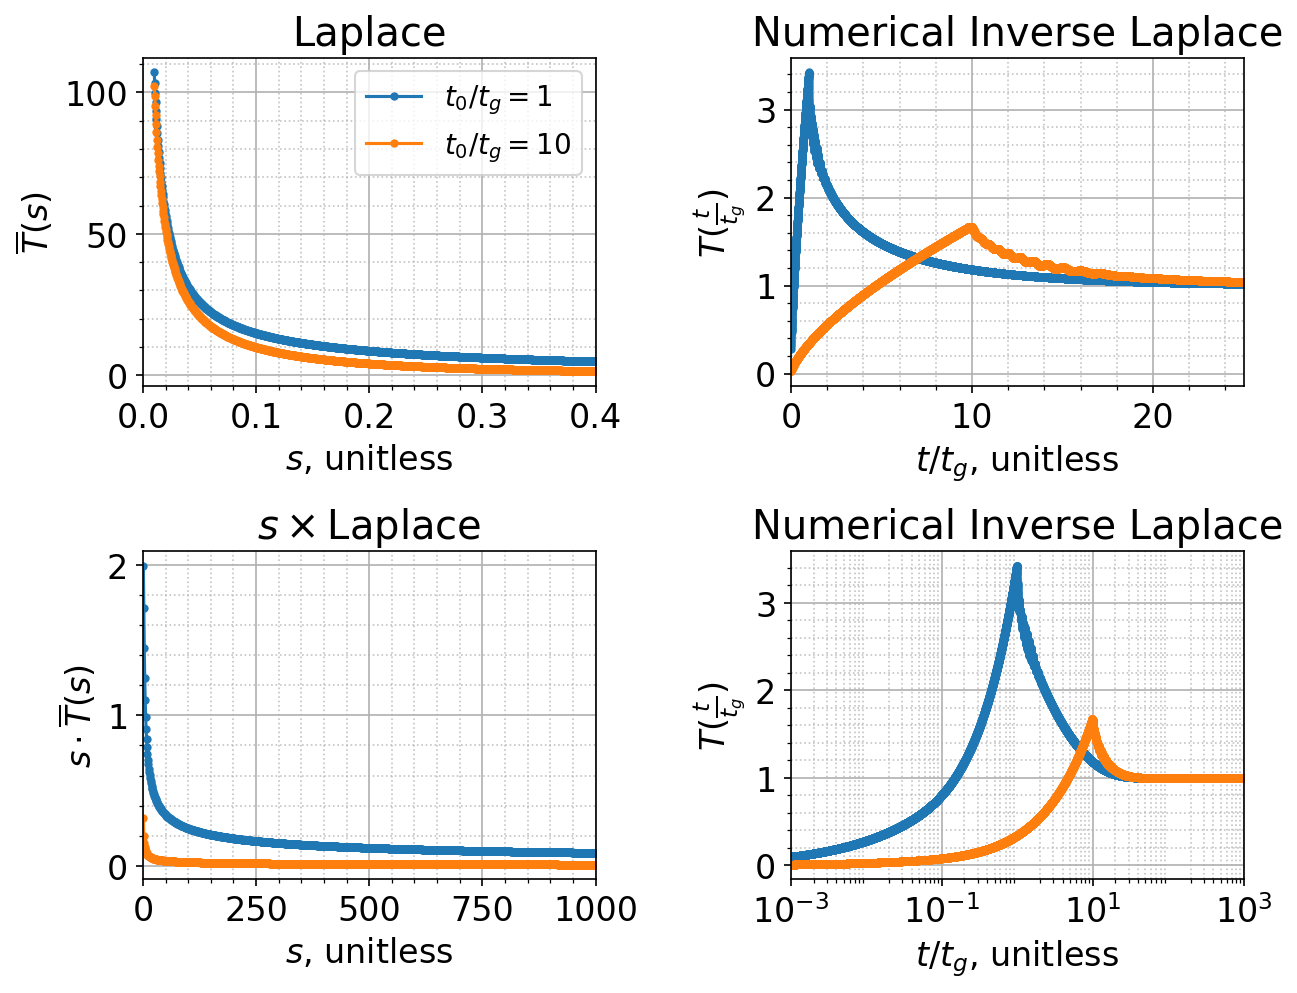

In [6]:
#@title # ViscoporoelasticModel2
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel2

VPEs = [(ViscoporoelasticModel2(t0_tg=t0_tg), fr"$t_0/t_g={t0_tg}$") 
                              for t0_tg in [1, 10]]
tg = VPEs[0][0].tg
t0_tg = VPEs[0][0].t0_tg

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
plot_times = np.linspace(0.01, 25, num=10001, endpoint=True)*tg
#plot_times = np.logspace(-3, 4, num=10001, endpoint=True)*tg
#input_times = plot_times
plot_times_log = np.logspace(-3, 3, num=10001, endpoint=True)*tg
input_times = np.concatenate((plot_times, plot_times_log))
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$T(\frac{t}{t_g})$", "s":r"$\overline{T}(s)$"}
x_names   = {"t":"$t/t_g$, unitless", "s":"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$T(\frac{t}{t_g})$"}, "x":{"name":"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{T}(s)$"},  "x":{"name":"$s$, unitless"}},
  }
plot_s = np.linspace(0.01, 0.4, num=1001, endpoint=True)
plot_s_s = np.linspace(1, 1000, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))

plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s, 
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)
ax01 = axs[0,1] if isinstance(axs[1], collections.abc.Container) else axs[1]
ax11 = axs[1,1] if isinstance(axs[1], collections.abc.Container) else axs[1]


ax_curr=ax11
ax_curr.axis("on")
for inverted_vals_numerical, func_label in zip(inverted_vals_numerical_all, func_labels):
    ax_curr.plot(plot_times_log/tg, inverted_vals_numerical[-len(plot_times_log):], ".-", label=func_label)
ax_curr.set_xlabel(plot_props.get("t").get("x").get("name"))   # plot_props["t"]["x"]["name"] 
#ax_curr.set_xscale(plot_props.get("t").get("x").get("scale") or "linear")
ax_curr.set_xscale("log")
ax_curr.set_xlim( [min(plot_times_log/tg), max(plot_times_log/tg)]) 
ax_curr.set_ylabel(plot_props.get("t").get("y").get("name"))  # plot_props["t"]["y"]["name"]
ax_curr.set_yscale(plot_props.get("t").get("y").get("scale") or "linear")
ax_curr.title.set_text("Numerical Inverse Laplace")
ax_curr.grid(which="major")
ax_curr.grid(which="minor", alpha=0.75, linestyle=":")
ax_curr.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10,subs=np.arange(2,10),numticks=10*ax01.xaxis.get_tick_space()))
ax_curr.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

"""result_ct = {"success":[], "fail":[]}
ax11.axis("on")

for key, val in ax01.properties().items():
  try:
    ax11.set(**{key: val})
    result_ct["success"].append((key,val))
  except:
    #print(f"Failed for {key}->{val}")
    result_ct["fail"].append((key,val))"""



df_params = pd.DataFrame([vpe.get_all_names_and_vars() for vpe, label in VPEs], index=[vpe.get_model_name() for vpe, label in VPEs])
display(df_params)

<IPython.core.display.Javascript object>

It took 0.0206 sec to evaluate the Laplace space func for 1097 input s vals.
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([   0, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([   0, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) compone

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,t0/tg,strain_rate,Vrz,Ezz,c,tau1,tau2,tg,Vrtheta,Err
ViscoporoelasticModel3 - Line #1,0.1,0.1,0.5,10,1,0.1,10,40.62,0.55,8.49
ViscoporoelasticModel3 - Line #2,0.1,0.1,0.5,10,1,0.1,10,40.62,0.60,8.49
ViscoporoelasticModel3 - Line #3,0.1,0.1,0.5,10,1,0.1,10,40.62,0.65,8.49
ViscoporoelasticModel3 - Line #4,0.1,0.1,0.5,10,1,0.1,10,40.62,0.75,8.49
ViscoporoelasticModel3 - Line #5,0.1,0.1,0.5,10,1,0.1,10,40.62,0.85,8.49
ViscoporoelasticModel3 - Line #6,0.1,0.1,0.5,10,1,0.1,10,40.62,0.90,8.49
ViscoporoelasticModel3 - Line #7,0.1,0.1,0.5,10,1,0.1,10,40.62,0.95,8.49


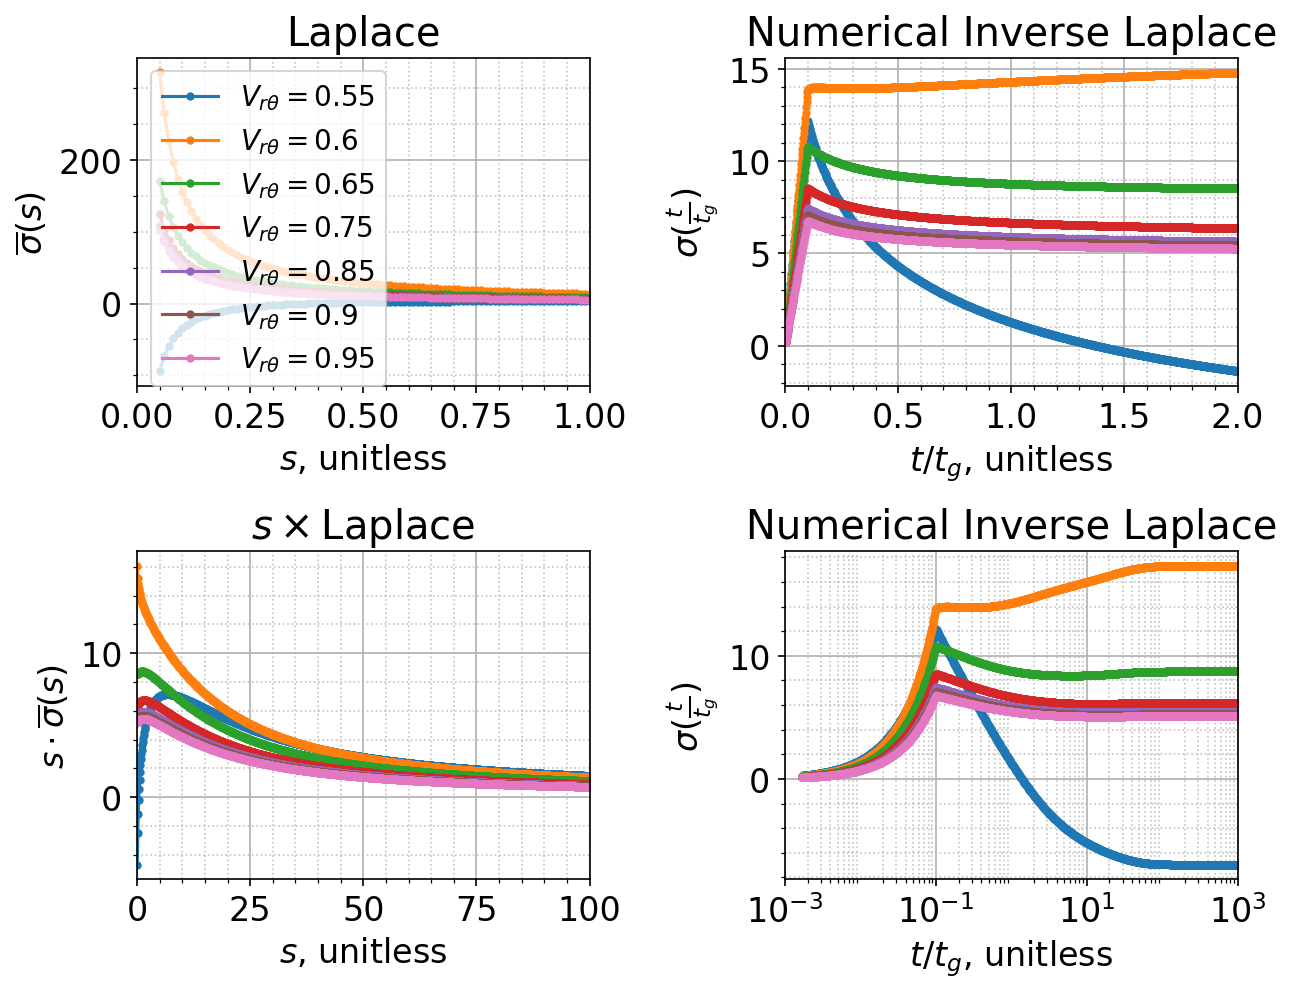

In [32]:
#@title # ViscoporoelasticModel3
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel3

#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
c =   1 #@param {type:"number"} ;
tau1 =  0.1 #@param {type:"number"} ;  # units = sec
tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
Err =  8.49 #@param {type:"number"};

VPEs = [(ViscoporoelasticModel3(c=c,
                               tau1=tau1,
                               tau2=tau2, 
                               tg=tg, 
                               Vrtheta=Vrtheta, 
                               Err=Err), fr"$V_{{r\theta}}={Vrtheta}$") 
                              for Vrtheta in [0.55, 0.6, 0.65, 0.75, 0.85, 0.9, 0.95]]

t0_tg = VPEs[0][0].t0_tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
plot_times_log = np.logspace(-3, 3, num=1001, endpoint=True)*tg
input_times = np.concatenate((plot_times, plot_times_log))
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":r"$t/t_g$, unitless", "s":r"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$\sigma(\frac{t}{t_g})$"}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{\sigma}(s)$"},  "x":{"name":r"$s$, unitless"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)
plot_s_s = np.linspace(0.05, 100, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)

ax01 = axs[0,1] if isinstance(axs[1], collections.abc.Container) else axs[1]
ax11 = axs[1,1] if isinstance(axs[1], collections.abc.Container) else axs[1]


ax_curr=ax11
ax_curr.axis("on")
for inverted_vals_numerical, func_label in zip(inverted_vals_numerical_all, func_labels):
    ax_curr.plot(plot_times_log/tg, inverted_vals_numerical[-len(plot_times_log):], ".-", label=func_label)
ax_curr.set_xlabel(plot_props.get("t").get("x").get("name"))   # plot_props["t"]["x"]["name"] 
#ax_curr.set_xscale(plot_props.get("t").get("x").get("scale") or "linear")
ax_curr.set_xscale("log")
ax_curr.set_xlim( [min(plot_times_log/tg), max(plot_times_log/tg)]) 
ax_curr.set_ylabel(plot_props.get("t").get("y").get("name"))  # plot_props["t"]["y"]["name"]
ax_curr.set_yscale(plot_props.get("t").get("y").get("scale") or "linear")
ax_curr.title.set_text("Numerical Inverse Laplace")
ax_curr.grid(which="major")
ax_curr.grid(which="minor", alpha=0.75, linestyle=":")
ax_curr.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10,subs=np.arange(2,10),numticks=10*ax01.xaxis.get_tick_space()))
ax_curr.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())


#output = r"\sigma(\frac{t}{tg})=0.7793021503277179 \text{ at } t/tg=150"
#display(IPython.display.Math(output))
itemindex = np.abs(input_times/tg - t0_tg).argmin()
for laplace_vals, inverted_vals_numerical, inverted_vals_analytical in zip(laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all):
  display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
  display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
  display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:0.3f}"))


for vpe, label in VPEs:
  df1 = pd.DataFrame({'Constant':vpe.get_predefined_constant_names(),'Value':vpe.get_predefined_constants()})
  df2 = pd.DataFrame({'Fitted':vpe.get_fitted_parameter_names(),'Value':vpe.get_fitted_parameters()})
  df3 = pd.DataFrame({'Value':vpe.get_predefined_constants()+vpe.get_fitted_parameters(),"Category":vpe.get_var_categories()}, index=vpe.get_predefined_constant_names()+vpe.get_fitted_parameter_names())
  #display(df3)

#df_params = pd.DataFrame(vpe.get_all_names_and_vars(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_all_names_and_vars() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_all_names_and_vars(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_all_names_and_vars() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

# Laplace function relevant properties - for diagnosing errors
## Sources:
*   https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceProps.html
*   https://lpsa.swarthmore.edu/LaplaceZTable/Common%20Laplace%20Transform%20Pairs.pdf

## Properties:  
1. Initial Value Theorem   
image.png

1. Final Value Theorem   
image.png

1. Time scaling.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgB1.gif)

1. Multiplication by time.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgAF.gif)

#Bessel info
Source: wolfram alpha

image.png

image.png

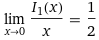

Source: https://www.mathworks.com/help/matlab/ref/besseli.html
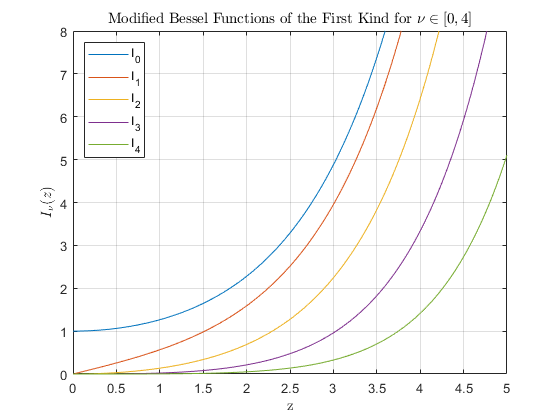

Source: http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap4.pdf
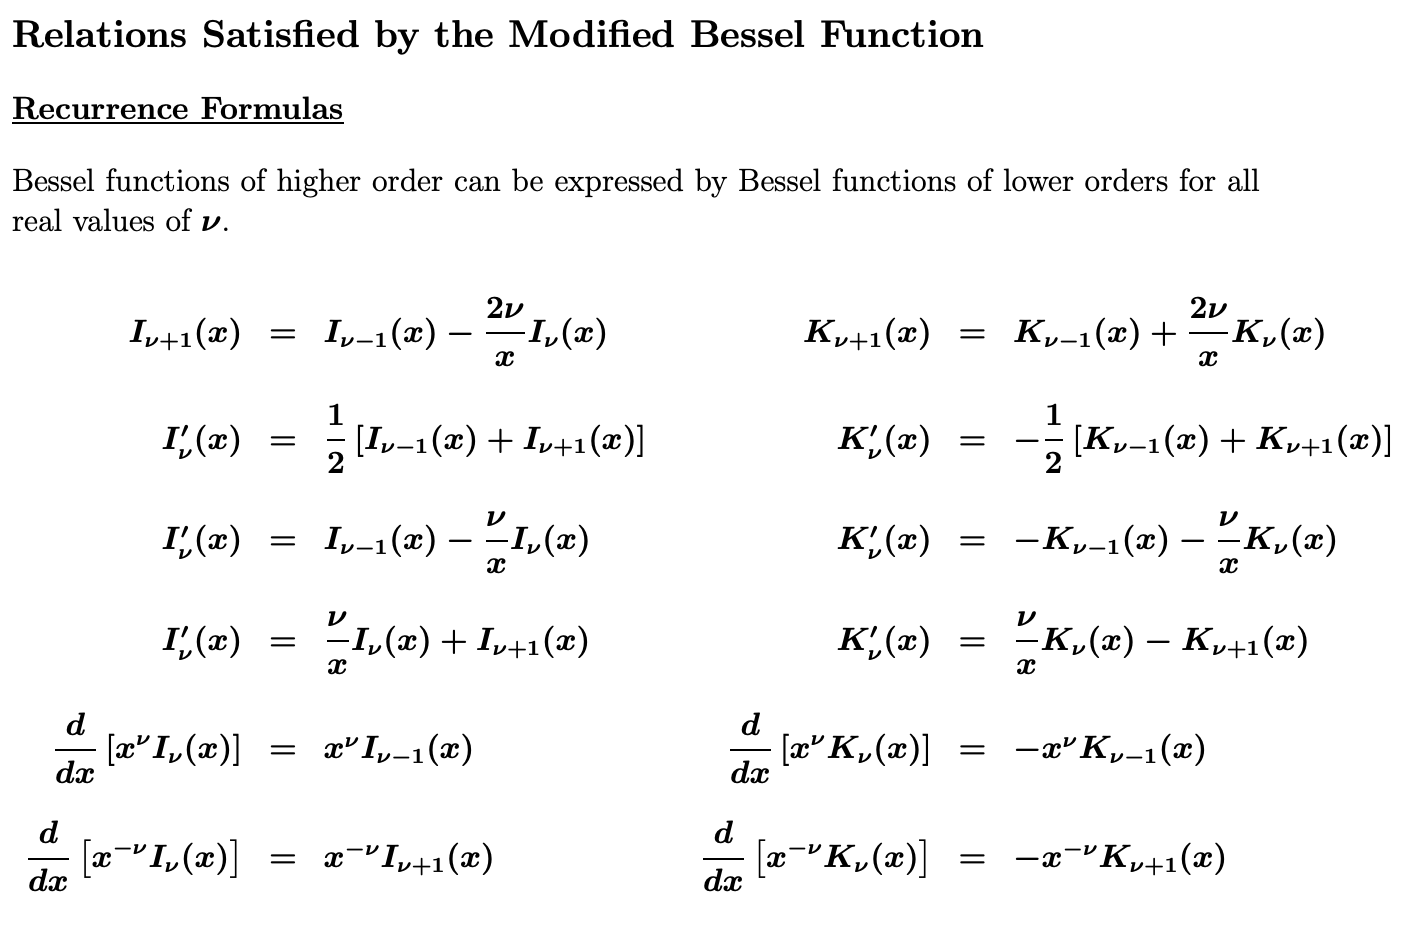

# Hyperbolic Trig Definitions
Source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions on 2021_07_13

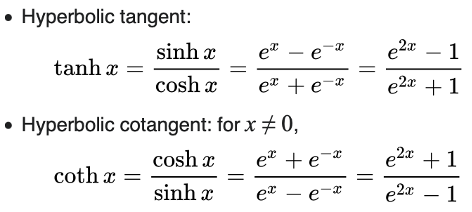